In [1]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
import IPython

from sklearn import metrics
import os


In [2]:
PATH = "Bulldoze Data/"
df_raw_d = pd.read_csv(f'{PATH}Train.csv', parse_dates=["saledate"], low_memory=False)
df_raw_d.SalePrice = np.log(df_raw_d.SalePrice)

# Data Processing

In [3]:
# Cleaning Data
import pandas.api.types as ptypes

df_raw = df_raw_d.copy()

for n, c in df_raw.items():
    if ptypes.is_string_dtype(c): df_raw[n] = c.astype('category').cat.as_ordered()

df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered = True, inplace=True)
df_raw.isnull().sum().sort_index()/len(df_raw)

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

In [4]:
# Transforming datetime column
prefix = 'sale'
attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
df_raw.saledate = pd.to_datetime(df_raw.saledate, infer_datetime_format=True)
#df_raw.sort_values(by='saledate', inplace=True)
#df_raw.reset_index(inplace=True)
for i in attr:
    df_raw[prefix+i] = getattr(df_raw.saledate.dt, i.lower())
df_raw[prefix+'Elapsed'] = pd.to_datetime(df_raw.saledate, infer_datetime_format=True).astype(np.int64)
df_raw.drop('saledate', axis = 1, inplace = True)

In [5]:
# to save fast
os.makedirs('tmp', exist_ok = True)
df_raw.to_feather('tmp/raw')

In [6]:
# to read fast
df_raw = pd.read_feather('tmp/raw')

In [7]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

## Major processing 
Replace strings with numeric codes, handle missing values, and split the dependent variable into a separate variable

In [8]:
df_bull = df_raw.copy()

# Splitting dependent variable
#y = df.SalePrice
#df.drop('SalePrice', axis = 1, inplace = True)

# Fixing continuous missing values and numeric codes (-1 to 0)
import pandas.api.types as ptypes
for n,c in df_bull.items():
    if ptypes.is_numeric_dtype(c):
        if pd.isnull(c).sum(): 
            df_bull[n+'_na'] = pd.isnull(c)
            df_bull[n] = c.fillna(c.median())
    if not ptypes.is_numeric_dtype(c):
        df_bull[n] = c.cat.codes+1

In [9]:
rf_full = RandomForestRegressor(n_jobs = -1)
y = df_bull.SalePrice
rf_full.fit(df_bull.drop('SalePrice', axis = 1), y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [10]:
df_bull.shape

(401125, 67)

Even though the R^2 score is high, we may have an issue with overfitting. Additionally, it takes a long time to complete training for the above formula, so we are going to train on the subset of data for tuning.

# Validation Sets
Validation sets ensure that the model generalizes well beyond training sets. We are trying to predict prices in the future, so we are going to write up a validation split function that trains on past data and validates on the latest from train.csv

In [11]:
def split_vals(a, n): return a[:n].copy(), a[n:].copy()

n_valid = 12000 # same as Kaggle's test set size
n_trn = len(df_bull) - n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train_big, X_valid = split_vals(df_bull, n_trn)
y_train_big, y_valid = X_train_big.SalePrice, X_valid.SalePrice

y_train_big = np.array(y_train_big)
y_valid = np.array(y_valid)

X_train_big.drop('SalePrice', axis = 1, inplace = True)
X_valid.drop('SalePrice', axis = 1, inplace = True)

X_train_big.shape, y_train_big.shape, X_valid.shape, y_valid.shape

((389125, 66), (389125,), (12000, 66), (12000,))

In [12]:
import math
def rmse(predicted, true_vals): return math.sqrt(((predicted-true_vals)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [14]:
m = RandomForestRegressor(n_jobs = -1)
m.fit(X_train_big, y_train_big)
[rmse(m.predict(X_train_big), y_train_big), rmse(m.predict(X_valid), y_valid),
                m.score(X_train_big, y_train_big), m.score(X_valid, y_valid)]

[0.07570272760467375,
 0.23480627837342413,
 0.9880227288559721,
 0.901538287670831]

This is really high! We get 90% accuracy for the validation set with all the default parameters of the RF model. Now, we would want to tune the model up to get it even more accurate, but first we need to speed things up.

## Speeding training up
We are going to subset train dataframe to speed up training of complex models faster and find optimal parameters

In [118]:
def get_sample(df,n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

df_trn = get_sample(df_bull, n=30000)
y_trn = df_trn.SalePrice

X_train, _ = split_vals(df_trn, 20000)
y_train = X_train.SalePrice

X_train.drop('SalePrice', axis = 1, inplace = True)
X_train.shape

(20000, 66)

In [16]:
rf = RandomForestRegressor(n_jobs = -1)
rf.fit(X_train, y_train)
print_score(rf)

[0.0943134070526786, 0.338798612351943, 0.9808707301198105, 0.7950106870939397]


Before we jump into hyperparameter tuning, let's visualize single decision tree to better understand what is happening in the random forest

# Single Tree
Let's first focus on a single tree and tune random forest from there. Best splits are combinations of variables and splits such that the resulting dependent variable groups are as different from each other as possible. For each variable for each possible value of that variable we see whether the split is better than the other variables' splits based on the weighted average of the RMSE.

In [17]:
rf_1 = RandomForestRegressor(n_estimators = 1, max_depth = 3, bootstrap = False, n_jobs = -1)
rf_1.fit(X_train, y_train)
print_score(rf_1)

[0.5304648571503199, 0.5797389296567196, 0.3948475978583238, 0.39977662747873666]


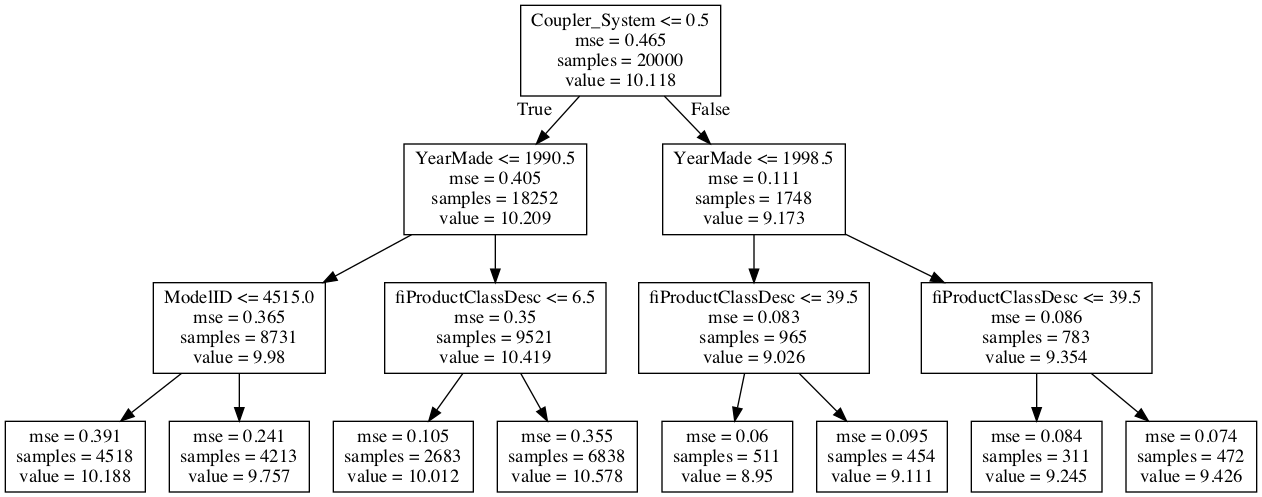

In [119]:
# Load libraries

from IPython.display import Image  
from sklearn import tree
import pydotplus

# Create DOT data
dot_data = tree.export_graphviz(rf_1.estimators_[0], out_file=None, 
                                feature_names=X_train.columns)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

In [19]:
rf_1d = RandomForestRegressor(n_estimators = 1, bootstrap = False, n_jobs = -1)
rf_1d.fit(X_train, y_train)
print_score(rf_1d)

[4.864753555590494e-17, 0.5170339030151102, 1.0, 0.5225960398087806]


# Random Forests
Random Forests is a way of bagging regular decision trees! So, let us first understand bagging.

## Bagging
You can bag any kind of model. Bagging - what if we created 5 different model, which are weak individually, but the models weren't predicted with each other - 5 models would have found different insights, so if you took the average - you are brining insights from each model. That is an example of an ensemble. Each has random UNCORRELATED errors - and when we average we get error of 0! Picks out rows to train each model on with replacement - so could be double. Impotant to create uncorrelted trees than accuracte trees for RF

In [20]:
np.random.seed(1234)
m = RandomForestRegressor(n_jobs=-1, n_estimators = 100)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 38.2 s, sys: 529 ms, total: 38.7 s
Wall time: 13.7 s
[0.09369429241655373, 0.3417464899065718, 0.9811210516660327, 0.7914279550575253]


In [21]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
(preds[:,0], np.mean(preds[:,0]), list(y_valid)[0])

(array([ 8.9226583 ,  9.51044496,  9.30565055,  8.98719682,  9.21034037,
         9.47270464,  8.95544812,  9.04782144,  9.21034037,  9.43348392,
         9.04782144,  9.04782144,  8.98719682,  9.18502256,  9.74096862,
         8.98719682,  9.21034037,  9.35010231,  9.83894903,  9.24956109,
         8.9226583 ,  9.21034037,  9.54681261,  9.21034037,  9.21034037,
         9.35010231,  9.10497986,  9.21034037,  9.83894903, 10.04324949,
         9.43348392,  8.9226583 ,  8.9226583 ,  9.30565055,  9.04782144,
         9.47270464,  9.35010231,  9.21034037,  9.58190393,  9.47270464,
         8.9226583 ,  9.76995616,  9.04782144,  9.21034037,  9.35010231,
         9.47270464,  9.21034037,  9.47270464,  9.35010231,  9.18502256,
         9.54681261,  9.30565055,  8.98719682,  8.98719682,  9.21034037,
         9.21034037,  9.54681261,  9.71111566,  9.47270464,  9.30565055,
         9.25913054,  8.98719682,  9.07680898,  9.21034037,  9.21034037,
         9.76995616,  8.98719682,  9.21034037,  9.3

We can see that individually decision trees are doing an OK job at predicting individual data points from the validation set. However, when we average out predictions of all decision trees we get a relatively close result.

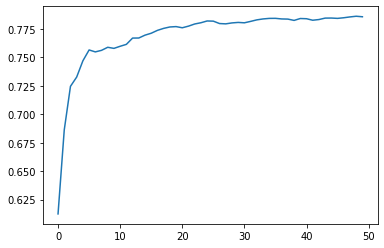

In [22]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(50)]);

The shape of this curve suggests that adding more trees isn't going to help us much. Let's check. (Compare this to our original model on a sample)

In [23]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.10197388510148761, 0.3393423733824981, 0.9776370311914254, 0.7943521563619504]


In [24]:
m = RandomForestRegressor(n_estimators=30, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09945134453770503, 0.35169946230778404, 0.9787297377569716, 0.7791022040236251]


In [25]:
m = RandomForestRegressor(n_estimators=50, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09667664927297875, 0.347199405853864, 0.9799000625496824, 0.7847188916771731]


From the above it we can clearly see that going above n_estimators of 30 has a small marginal effect on the validation score.

### Uncorrelated Trees
If you build 1000 trees on 10 datapoints than the predictions are going to be very different -> correlations between predictions will be small (individual trees are not generalizing very well). On the other hand, if we build 1000 trees on almost all data we will get highly correlated trees and predictions (no generalize very well).

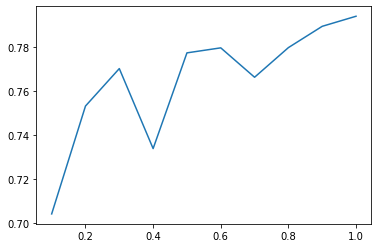

In [26]:
preds = []
for i in range(1,11):
    m = RandomForestRegressor(n_jobs=-1, max_features = i/10)
    m.fit(X_train, y_train)
    preds.append(m.predict(X_valid))

plt.plot(np.array([*range(1,11)])/10,[metrics.r2_score(y_valid, preds[i]) for i in range(10)]);

## Out-of-bag (OOB) score
Is our validation set worse than our training set because we're over-fitting, or because the validation set is for a different time period, or a bit of both? With the existing information we've shown, we can't tell. However, random forests have a very clever trick called out-of-bag (OOB) error which can handle this (and more!)

The idea is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was not included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set.

This also has the benefit of allowing us to see whether our model generalizes, even if we only have a small amount of data so want to avoid separating some out to create a validation set.

This is as simple as adding one more parameter to our model constructor.

In [27]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.0971790107362289, 0.344242755840424, 0.9796906289637263, 0.7883698237325424, 0.8566749674239507]


## Best Practice
Do most of the models on subsets of data! Speed at the beginning is key

In [28]:
def get_sample(df,n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

n_valid = 12000
n_trn = len(df_bull)-n_valid

X_train, X_valid = split_vals(df_bull.drop('SalePrice', axis = 1), n_trn)
y_train, y_valid = split_vals(y, n_trn)
raw_train, raw_valid = split_vals(df_bull, n_trn)
X_train.shape

(389125, 66)

### Ovoiding Overfitting
1. Subsampling (above)
2. Reduce the tree depth - min_samples_leaf = 3, not one
3. Reduce number of features available for each tree. For example, max_features = 0.5 - less correlation the better - what if every tree uses one very imortant column, but we might imagine there are some interactions that are important. So, in addition, to choosing subset of rows, at every split point we choose a different SUBSET of columns. Every possible level of a random subset of columns!
Trees are differnet on rows, max_features - indicates to use different columns

def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

### Summary of RF hyperparameters effects

set_rf_samples - rows in each tree, if rf_samples = 20000, then if tree is balanced, # of layers is log_2(20000), # of leaf nodes - 20000. decrease sample size - less final decisions - tree is less rich, less binary choices. Low - less overfitting, less accuract individual tree models. When building a bagging model - try to achive 2 things: each individual model is as accuracte as possible + across estimators - the correlation is as low as possible. So when we decrease the rf sample we decrease the power of the esimator but achive the 2nd thing: keeping the correlation low.

min_samples_leaf - if set it to 2 then # of layers is log_2(20000) - 2, each time we double min_samples_leaf we subtract one layer. Leaf nodes: 10k. Each leaf has more than one thing in it = more stable average. Less depth. Result - each esimator - less predictive, but also predictors will be less correlated. 
- 1, 3, 5, 10, 25, 100

max_features - at each split it will randomly pick differnt proportion of the features. We want the trees to be as rich as possible. Picking different subset of features at each decision point.
- None
- 0.5
- 'sqrt'



In [29]:
from sklearn.ensemble import forest

def set_rf_samples(n): 
    """ Changes Scikit learn's random forests to give each tree a random sample of n random rows. """ 
    forest._generate_sample_indices = (lambda rs, n_samples: forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples(): 
    """ Undoes the changes produced by set_rf_samples. """ 
    forest._generate_sample_indices = (lambda rs, n_samples: forest.check_random_state(rs).randint(0, n_samples, n_samples))

/Users/nyatchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


# Confidence based on tree variance
Let's continue using a subset of data and examine variability in predictions made by random forests.

In [30]:
set_rf_samples(50000)

m_rf = RandomForestRegressor(n_estimators = 70, min_samples_leaf = 3, max_features = 0.7, n_jobs = -1, oob_score = True)
m_rf.fit(X_train, y_train)
print_score(m_rf)

[0.11483275298341258, 0.2269224575029385, 0.9724408144128458, 0.9080391598341562, 0.9141564092541117]


How do we know how confident we are in the predictions made by the model above? We know we get them by averaging predictions made by single decision trees in a forest. One simple way os to use the standard deviation of predictions, instead of the mean. This tells us the relative confidence of predictions - that is, how much variability there is amongst prediction for specific row. Higher variability means less certainty in the prediction. Let's obtain standard deviation of the preditions:

In [31]:
preds = np.stack([t.predict(X_valid) for t in m_rf.estimators_])
(np.mean(preds[:, 0]), np.std(preds[:, 0]))

(9.144080479296145, 0.13023377328895075)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

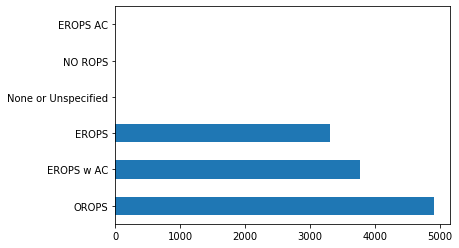

In [32]:
raw_train, raw_valid = split_vals(df_raw, n_trn)

x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [33]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.839120,0.242899
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.595917,0.225169
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.680346,0.199149


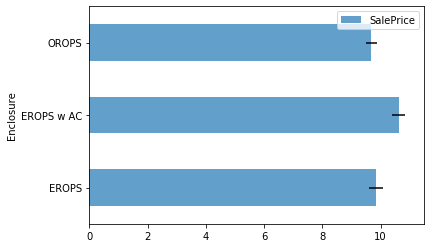

In [34]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', alpha = 0.7, xlim = (0,11.5), xerr = 'pred_std');

From the dataframe above we can clearly tell that the predictions are close, but the standard deviation is high - why is that ?

Let's investigate our train dataset and compare its ProductSize distribution to the validation set

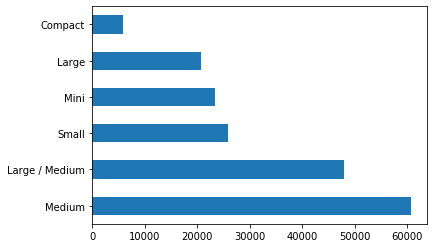

In [35]:
temp = X_train.ProductSize.astype('category').map(dict( zip( raw_valid.ProductSize.cat.codes + 1, raw_valid.ProductSize ) ))
temp.value_counts().plot.barh();

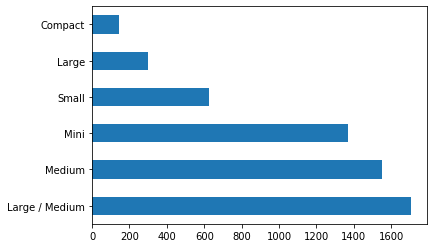

In [36]:
raw_valid.ProductSize.value_counts().plot.barh();

In [37]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.795297,0.273659
Large,10.470589,10.417941,0.317350
Large / Medium,10.691871,10.664259,0.265671
Medium,10.681511,10.634419,0.243384
Mini,9.535147,9.555149,0.209743
Small,10.324448,10.341153,0.260524


Comparing the 3 graphics above it makes sense that Large and Compact categories have the largest unceratinty. In the trianing set these categories are underrepresented vs what we see in the validation set.

# Feature Importance
It's not just enough to know that a model can make accurate predictions - we also would like to know how it is making those predictions. The most straightforward way to see this is whith feature importance

In [38]:
feat_imp = pd.DataFrame({'cols':X_train.columns, 'imp':m_rf.feature_importances_}
                       ).sort_values('imp', ascending=False)
print(len(feat_imp)); feat_imp.head(15)

66


,cols,imp
5,YearMade,0.175204
37,Coupler_System,0.150258
13,ProductSize,0.103504
14,fiProductClassDesc,0.092606
2,ModelID,0.069900
63,saleElapsed,0.061852
10,fiSecondaryDesc,0.038373
19,Enclosure,0.034384
8,fiModelDesc,0.033020
38,Grouser_Tracks,0.026140


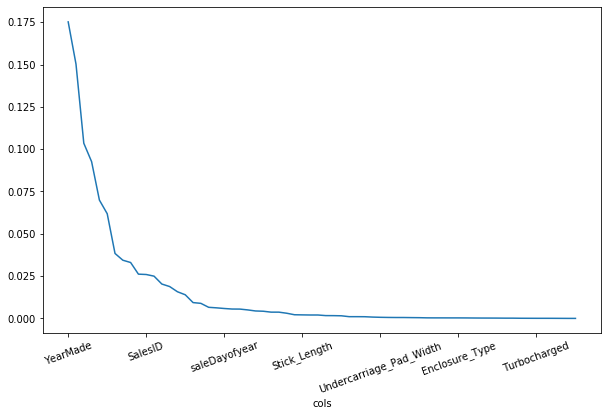

In [39]:
feat_imp.plot('cols', 'imp', figsize=(10,6), legend = False);
plt.xticks(rotation=20);

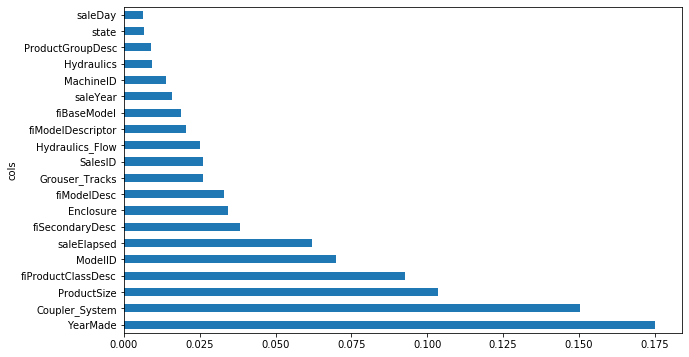

In [40]:
feat_imp.iloc[:20,:].plot('cols', 'imp', 'barh', legend = False, figsize = (10,6));

In [41]:
to_keep = feat_imp[feat_imp.imp>0.005].cols; to_keep = to_keep.append(pd.Series(['SalePrice']), ignore_index = True); len(to_keep)

25

Lookin at feature importance graph, we observe there are variables that are relatively unimportant. We will create a new random forest and see if excluding relatively irrelavent columns will yield similar or better results on the validation set.

In [42]:
df_keep = df_bull[to_keep].copy()
X_train, X_valid = split_vals(df_keep.drop('SalePrice', axis = 1), n_trn)

In [43]:
m_rf = RandomForestRegressor(n_estimators = 70, min_samples_leaf = 3, max_features = 0.7, 
                             n_jobs = -1, oob_score = True)
m_rf.fit(X_train, y_train)
print_score(m_rf)

[0.11962779643492673, 0.22421583423222155, 0.9700911970033683, 0.9102198073756396, 0.9120079468554488]


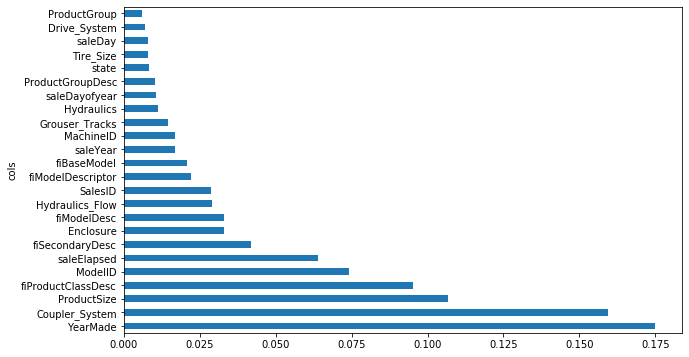

In [44]:
feat_imp_new = pd.DataFrame({'cols':X_train.columns, 'imp':m_rf.feature_importances_}
                       ).sort_values('imp', ascending=False)
feat_imp_new.plot('cols', 'imp', 'barh', legend = False, figsize = (10,6));

Now the random forest model is simpler, has less of an issue with overfitting, and reduced collinearity, while the validation score is the same.

## One-hot encoding
What if we reviewed how we encoded categorical variables? By encoding our categorical variables with codes we might be very inneficient with our tree computations, as with every split we are halfing data available for the next tree, making each individual tree less rich. By doing one-hot encoding, RF has the ability to evaluate a single level of the categorical variable and judge whether it is a good predictor.

In [45]:
def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes.
    Parameters:
    -----------
    df: A pandas dataframe. df[name] will be filled with the integer codes from
        col.
    col: The column you wish to change into the categories.
    name: The column name you wish to insert into df. This column will hold the
        integer codes.
    max_n_cat: If col has more categories than max_n_cat it will not change the
        it to its integer codes. If max_n_cat is None, then col will always be
        converted.
    """
    if not ptypes.is_numeric_dtype(col):
        temp = col.astype('category').cat.as_ordered()
        if( max_n_cat is None or len(temp.cat.categories)>max_n_cat):
            df[name] = pd.Categorical(col).codes+1

In [46]:
df_trn2 = df_raw_d.copy()

# Cleaning Data
import pandas.api.types as ptypes

max_n_cat = 7
for n, c in df_trn2.items():
    numericalize(df_trn2, c, n, max_n_cat)

df_trn2 = pd.get_dummies(df_trn2, dummy_na = True)

for n, c in df_trn2.items():
    if ptypes.is_string_dtype(c): df_trn2[n] = c.astype('category').cat.as_ordered()


# Transforming datetime column
prefix = 'sale'
attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
df_trn2.saledate = pd.to_datetime(df_trn2.saledate, infer_datetime_format=True)

for i in attr:
    df_trn2[prefix+i] = getattr(df_trn2.saledate.dt, i.lower())
df_trn2[prefix+'Elapsed'] = pd.to_datetime(df_trn2.saledate, infer_datetime_format=True).astype(np.int64)
df_trn2.drop('saledate', axis = 1, inplace = True)

# Fixing continuous missing values and numeric codes (-1 to 0)
import pandas.api.types as ptypes
for n,c in df_trn2.items():
    if ptypes.is_numeric_dtype(c):
        if pd.isnull(c).sum(): 
            df_trn2[n+'_na'] = pd.isnull(c)
            df_trn2[n] = c.fillna(c.median())
    if not ptypes.is_numeric_dtype(c):
        df_trn2[n] = c.cat.codes+1

In [47]:
X_train, X_valid = split_vals(df_trn2, n_trn)
y_train = X_train.SalePrice
y_valid = X_valid.SalePrice
X_train.drop('SalePrice', axis = 1, inplace = True)
X_valid.drop('SalePrice', axis = 1, inplace = True)

rf_dum = RandomForestRegressor(n_estimators = 70, min_samples_leaf = 3, max_features = 0.7, n_jobs = -1, oob_score = True)
rf_dum.fit(X_train, y_train)
print_score(rf_dum)

[0.12131539802489903, 0.23309128896648318, 0.9692413917413004, 0.902971333907924, 0.9119098819044786]


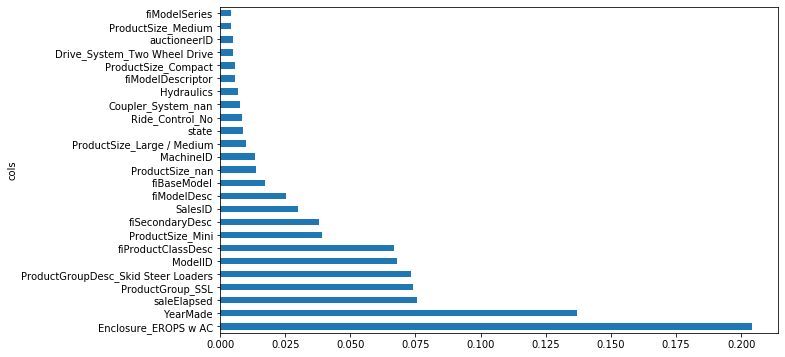

In [48]:
feat_imp_1he = pd.DataFrame({'cols':X_train.columns, 'imp':rf_dum.feature_importances_}
                       ).sort_values('imp', ascending=False)
feat_imp_1he[:25].plot('cols', 'imp', 'barh', legend = False, figsize = (10,6));

## Removing redundant features
There seem to be some variables with very simimiilar meanings. By going thorough the next step we are going to remove redundant features.

In [49]:
from scipy.cluster import hierarchy as hc

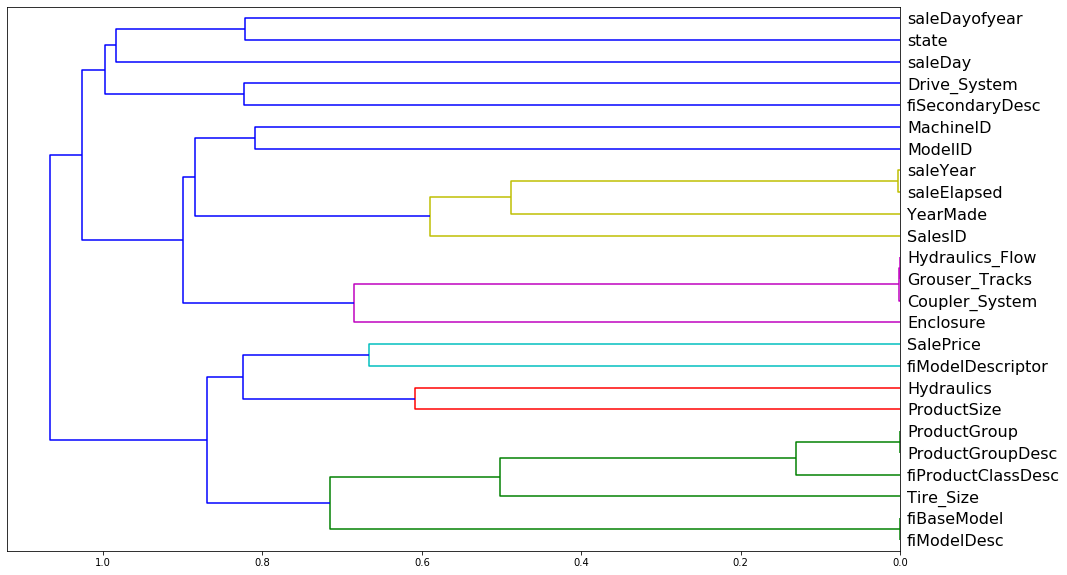

In [50]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [51]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

This is the baseline

In [52]:
get_oob(df_keep.drop('SalePrice', axis = 1))

0.9068085788033751

Now remove one variable at a time

In [53]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.9999842266047136


/Users/nyatchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


saleElapsed 0.9994309067113549
fiModelDesc 0.9999845965516474
fiBaseModel 0.999986177992455


/Users/nyatchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Grouser_Tracks 0.9987265500250011
Coupler_System 0.9999788250414521


In [54]:
to_drop = ['saleYear', 'fiModelDesc', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis = 1))

0.9999869441736327

Let's save the list of columns so we can resue it later

In [55]:
#df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep.drop('SalePrice', axis = 1), n_trn)

In [56]:
X_train.columns

Index(['YearMade', 'Coupler_System', 'ProductSize', 'fiProductClassDesc',
       'ModelID', 'saleElapsed', 'fiSecondaryDesc', 'Enclosure', 'fiModelDesc',
       'Grouser_Tracks', 'SalesID', 'Hydraulics_Flow', 'fiModelDescriptor',
       'fiBaseModel', 'saleYear', 'MachineID', 'Hydraulics',
       'ProductGroupDesc', 'state', 'saleDay', 'saleDayofyear', 'Drive_System',
       'Tire_Size', 'ProductGroup'],
      dtype='object')

In [57]:
np.save('tmp/keep_cols.npy', np.array(df_keep.drop('SalePrice', axis = 1).columns))

In [58]:
keep_cols = np.load('tmp/keep_cols.npy', allow_pickle=True)
df_keep = df_bull[keep_cols]
keep_cols

array(['YearMade', 'Coupler_System', 'ProductSize', 'fiProductClassDesc',
       'ModelID', 'saleElapsed', 'fiSecondaryDesc', 'Enclosure',
       'fiModelDesc', 'Grouser_Tracks', 'SalesID', 'Hydraulics_Flow',
       'fiModelDescriptor', 'fiBaseModel', 'saleYear', 'MachineID',
       'Hydraulics', 'ProductGroupDesc', 'state', 'saleDay',
       'saleDayofyear', 'Drive_System', 'Tire_Size', 'ProductGroup'],
      dtype=object)

In [59]:
reset_rf_samples()

In [60]:
rf_full = RandomForestRegressor(n_estimators=70, min_samples_leaf=3, max_features=0.7, n_jobs=-1, oob_score=True)
rf_full.fit(X_train, y_train)
print_score(rf_full)

[0.1194164653787505, 0.22391406445294323, 0.9701967757428662, 0.9104613132170469, 0.9123383458766379]


In [61]:
df_keep.YearMade[df_keep.YearMade<1940] = 1940
df_keep['age'] = df_raw.saleYear - df_raw.YearMade

/Users/nyatchen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/nyatchen/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/Users/nyatchen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [62]:
df_keep.columns

Index(['YearMade', 'Coupler_System', 'ProductSize', 'fiProductClassDesc',
       'ModelID', 'saleElapsed', 'fiSecondaryDesc', 'Enclosure', 'fiModelDesc',
       'Grouser_Tracks', 'SalesID', 'Hydraulics_Flow', 'fiModelDescriptor',
       'fiBaseModel', 'saleYear', 'MachineID', 'Hydraulics',
       'ProductGroupDesc', 'state', 'saleDay', 'saleDayofyear', 'Drive_System',
       'Tire_Size', 'ProductGroup', 'age'],
      dtype='object')

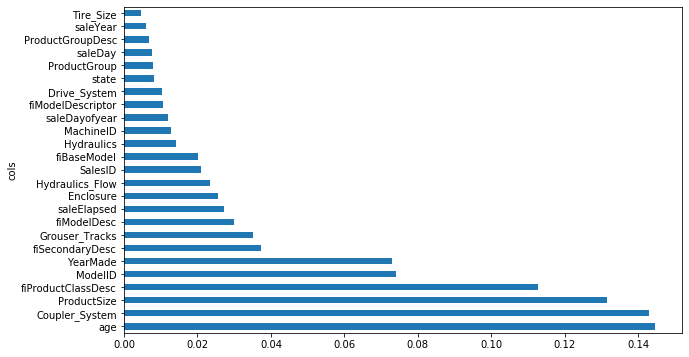

In [94]:
X_train, X_valid = split_vals(df_keep, n_trn)
rf_m = RandomForestRegressor(n_estimators = 70, min_samples_leaf = 3, max_features = 0.7, n_jobs = -1)
rf_m.fit(X_train, y_train)
feat_imp = pd.DataFrame({'cols':X_train.columns, 'imp':rf_m.feature_importances_}
                       ).sort_values('imp', ascending=False)
feat_imp[:25].plot('cols', 'imp', 'barh', legend = False, figsize = (10,6));

In [64]:
print_score(rf_m)

[0.11946378571400228, 0.22304119219576246, 0.9701731512287166, 0.911158040333895]


# Tree interpreter
It is important to understand WHY the model is making a certain prediction - treeinterpreter does exactly that. The RF model creates multiple trees by creating best splits in data, like YearMade > 1999.5, Enclosure <= 2.0. Each group has an average log(SalePrice) associated with the split. What treeinterpreter does is it traces the values of the particular row with the RF splits and records the marginal change in log(SalePrice), dependent variable. So that we can see how each variable contributed to the final prediction.

In [65]:
from treeinterpreter import treeinterpreter as ti

In [66]:
df_train, df_valid = split_vals(df_keep, n_trn)

In [67]:
row = X_valid.values[None,0]; row

array([[               1999,                   0,                   5,
                         17,                 665, 1284595200000000000,
                          0,                   1,                3232,
                          0,             4364751,                   0,
                          0,                1111,                2010,
                    2300944,                  12,                   4,
                         35,                  16,                 259,
                          0,                   0,                   4,
                         11]])

In [68]:
prediction, bias, contributions = ti.predict(rf_m, row)

In [69]:
prediction[0], bias[0]

(array([9.16945323]), 10.105434350067865)

In [70]:
idxs = np.argsort(contributions[0])

In [71]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 5, -0.6128835098249938),
 ('age', 11, -0.17112487871747983),
 ('fiProductClassDesc', 17, -0.11217624083560135),
 ('fiModelDesc', 3232, -0.11060302674445467),
 ('fiSecondaryDesc', 0, -0.10309281670802195),
 ('fiBaseModel', 1111, -0.07772037116143855),
 ('saleElapsed', 1284595200000000000, -0.018959051102613676),
 ('Enclosure', 1, -0.01624431535268846),
 ('fiModelDescriptor', 0, -0.014137050698703035),
 ('saleYear', 2010, -0.008129303931706947),
 ('Tire_Size', 0, -0.002138616058852426),
 ('SalesID', 4364751, -0.0018557288863585493),
 ('state', 35, -0.0008290481570321211),
 ('MachineID', 2300944, -0.0006526458862023077),
 ('saleDayofyear', 259, -5.8706067101458155e-05),
 ('ProductGroupDesc', 4, 0.0022331562615322906),
 ('saleDay', 16, 0.003433819219844812),
 ('Drive_System', 0, 0.0035409214392561695),
 ('ProductGroup', 4, 0.009751283992425691),
 ('Hydraulics_Flow', 0, 0.010503043104648313),
 ('Grouser_Tracks', 0, 0.015060955654871578),
 ('Hydraulics', 12, 0.01583596804231

In [72]:
contributions[0].sum()

-0.9359811175471612

# Extrapolation
It is hard to extrapolate with Random Forests. RF models do well with find points that closely resemble points in the train data set, but how would you extrapolate into the future? Well, one tactic would be to eliminate time dependent variables and focus on variables that prove to be time independent.

In [99]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
y = df_ext.is_valid
x = df_ext.drop('is_valid', axis = 1)

/Users/nyatchen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Create a new column 'is_valid' and now we are training the RF model to predict whether we can predict a validation set. If our variables were not time dependent, then it would be tough to predict validation set.

In [74]:
m = RandomForestRegressor(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5, n_jobs = -1, oob_score = True)
m.fit(x,y)
m.oob_score_

0.9998852264673226

We do not have a random set, since we can easily predict validation set

In [75]:
feat_imp_ext = pd.DataFrame({'cols' : x.columns, 'imp' : m.feature_importances_}).sort_values(by = 'imp', ascending = False)
feat_imp_ext

,cols,imp
10,SalesID,0.733694
5,saleElapsed,0.156594
14,saleYear,0.048410
15,MachineID,0.040338
20,saleDayofyear,0.011150
8,fiModelDesc,0.002329
4,ModelID,0.002137
13,fiBaseModel,0.000984
6,fiSecondaryDesc,0.000882
0,YearMade,0.000745


We can clearly see that SalesID, saleElapsed, and MachineID are at the top of being most important for predicting whether it is a validation set. Thus these are the variables that are time dependent. Maybe there is a structure to how SalesID is named and coded.

In [95]:
feats_time = ['SalesID', 'MachineID', 'saleElapsed', 'saleYear', 'saleDayofyear']

In [96]:
(X_train[feats_time]/1000).describe()

,SalesID,MachineID,saleElapsed,saleYear,saleDayofyear
count,389125.000000,389125.000000,3.891250e+05,389125.000000,389125.000000
mean,1800.452485,1206.796148,1.084797e+15,2.003892,0.177640
std,595.627288,430.850552,1.803913e+14,0.005721,0.103249
min,1139.246000,0.000000,6.009984e+14,1.989000,0.002000
25%,1413.348000,1087.016000,9.666432e+14,2.000000,0.084000
50%,1632.093000,1273.859000,1.134605e+15,2.005000,0.166000
75%,2210.453000,1458.661000,1.234138e+15,2.009000,0.270000
max,4364.741000,2313.821000,1.325117e+15,2.011000,0.365000


In [97]:
(X_valid[feats_time]/1000).describe()

,SalesID,MachineID,saleElapsed,saleYear,saleDayofyear
count,12000.000000,12000.000000,1.200000e+04,12000.000000,12000.000000
mean,5786.967651,1578.049709,1.306609e+15,2.010707,0.255770
std,836.899608,589.497173,2.497808e+13,0.000667,0.082982
min,4364.751000,0.830000,1.174522e+15,2.007000,0.033000
25%,4408.580750,1271.225250,1.309219e+15,2.011000,0.207000
50%,6272.538500,1825.317000,1.316045e+15,2.011000,0.266000
75%,6291.792250,1907.858000,1.321402e+15,2.011000,0.335000
max,6333.342000,2486.330000,1.325203e+15,2.011000,0.364000


In [100]:
x.drop(feats_time, axis = 1, inplace = True)

In [101]:
m = RandomForestRegressor(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5, n_jobs = -1, oob_score = True)
m.fit(x,y)
m.oob_score_

0.3732297082808408

In [102]:
feat_imp_ext = pd.DataFrame({'cols' : x.columns, 'imp' : m.feature_importances_}).sort_values(by = 'imp', ascending = False)
feat_imp_ext

,cols,imp
19,age,0.171252
15,saleDay,0.152191
0,YearMade,0.143726
14,state,0.116295
4,ModelID,0.098244
7,fiModelDesc,0.061789
11,fiBaseModel,0.050796
3,fiProductClassDesc,0.040362
6,Enclosure,0.030283
5,fiSecondaryDesc,0.026411


In [108]:
set_rf_samples(50000)

In [109]:
feats = ['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

these are all time dependent variables - let's see what happens to our validation score if we removed one of them

In [110]:
rf_m = RandomForestRegressor(n_estimators = 70, min_samples_leaf = 3, max_features = 0.7, n_jobs = -1)
rf_m.fit(X_train, y_train)
print_score(rf_m)

[0.12208194955230736, 0.22599500142129383, 0.9688514569190364, 0.9087893310382884]


<b>The goal now is to find a set of generalizable across time predictors</b>

In [111]:
for f in feats:
    df_subs = df_keep.drop(f, axis = 1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators = 70, min_samples_leaf = 3, max_features = 0.7, n_jobs = -1)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.1226466832512844, 0.21994919946625296, 0.9685626129434164, 0.9136041771529001]
saleElapsed
[0.12204694206831028, 0.22588412750973574, 0.968869318294687, 0.9088788056096074]
MachineID
[0.12246765678442827, 0.22042061002133131, 0.9686543238077779, 0.9132334411070037]
age
[0.11952971647318933, 0.2239852206242749, 0.9701402199195557, 0.9104043963593352]
YearMade
[0.11980578397472268, 0.22500203822089382, 0.9700021315083344, 0.909589082088067]
saleDayofyear
[0.12253467040480046, 0.22360587055637493, 0.9686200100629953, 0.9107076245495557]


We see that excluding SalesID, MachineID and saleDayofyear - the validation score has gone up. Additionally, they were not that important when we performed our feature importance when predicting SalePrice. Thus we will exclude these variables from our final model.

In [112]:
reset_rf_samples()

In [113]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis = 1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators = 70, min_samples_leaf = 3, max_features = 0.7, n_jobs = -1, oob_score = True)
m.fit(X_train, y_train)
print_score(m)

[0.13119356945210955, 0.21603873008447627, 0.9640283861488537, 0.9166489249831159, 0.9116506801261179]


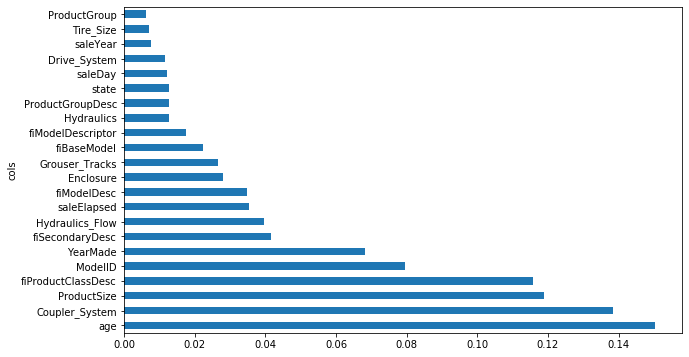

In [114]:
feat_imp_f = pd.DataFrame({'cols' : X_train.columns, 'imp' : m.feature_importances_}).sort_values(by = 'imp', ascending = False)
feat_imp_f.plot('cols', 'imp', 'barh', legend = False, figsize=(10,6));

In [115]:
np.save('tmp/subs_cols.np', np.array(df_subs.columns))

# Final Model!

In [116]:
rf_final = RandomForestRegressor(n_estimators = 160, max_features = 0.7, n_jobs = -1, oob_score = True)
rf_final.fit(X_train, y_train)
print_score(rf_final)

[0.08022456280165742, 0.21072480135253868, 0.9865491557449062, 0.9206988874627023, 0.9144943969645489]
